<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/PAPER_GDRNet_ELECTRICITY_Step2-3-Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3834/3834 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
r2 score is == 0.38406103293762295


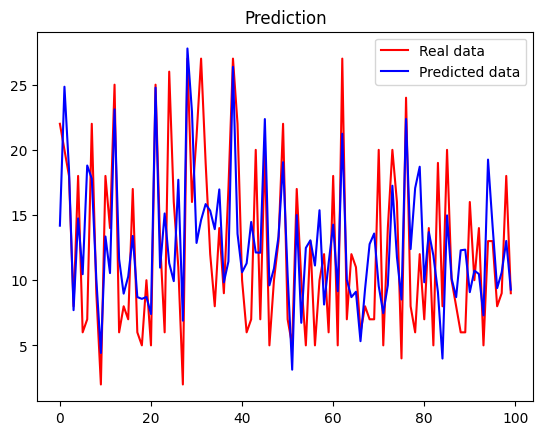

426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
r2 score is == 0.30659435658112233


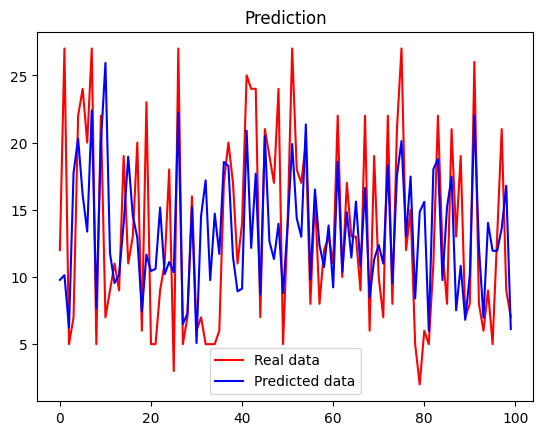

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
import keras
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import saving

import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import Callback
import plotly
from keras import losses

import plotly.express as px # for data visualization
#from keras.utils import plot_model
#import matplotlib.pyplot as plt

#window1 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-500.npy')
#window2 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-1000.npy')
#window = np.concatenate((window1, window2), axis=0)
#train_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TRAIN.npy')
#test_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TEST.npy')


train_data = np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/multivariate_long_sequences-TRAIN-DATA-FullSearch-VAR.npy')
#test_data = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences-TEST_hourly.npy')
window_label = np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/multivariate_long_sequences_TRAIN-WINDOW-FullSearch-VAR.npy')

test_data = np.load('/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/multivariate_long_sequences-TEST-DATA-FullSearch-VAR.npy')
window_label_test = np.load('/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/multivariate_long_sequences_TEST-WINDOW-FullSearch-VAR.npy')


n_seq = train_data.shape[0]
window_size = train_data.shape[1]
n_features = train_data.shape[2]


maxval = train_data.shape[0]
count_train = int(math.ceil(0.8*maxval))
x_train = train_data[:count_train]
x_test = train_data[count_train:]
#x_test = train_data[count_train:,:,:]

# Clear all previously registered custom objects
saving.get_custom_objects().clear()
# Create a custom layer
@saving.register_keras_serializable(package="MyLayers")
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, factor):
        super().__init__()
        self.factor = factor


    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return {"factor": self.factor}

#Build the encoder
latent_dim = 5
intermediate_dim = 256


#Encoder
encoder_inputs =  layers.Input(shape=(window_size, n_features),name="encoder_input")
x = layers.LSTM(intermediate_dim, activation='tanh', name="lstm1", return_sequences=True)(encoder_inputs)
xx = layers.LSTM(int(intermediate_dim/2), activation='tanh', name="lstm2", return_sequences=False)(x)
x1 = layers.Dense(int(intermediate_dim/2), name="dense" )(xx)
z_mean = layers.Dense(latent_dim, name="z_mean")(x1)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x1)
z = Sampling(1)([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


#Dcoder

inp_z = Input(shape=(latent_dim,),name="decoder")
x1 = layers.RepeatVector(window_size, name="repeatvect")(inp_z)
x2= layers.Dense(int(intermediate_dim/2),  name="Dense2")(x1)
x22= layers.LSTM(int(intermediate_dim/2),activation='tanh', return_sequences=True, name="lstm1")(x2)
x3 = layers.LSTM(intermediate_dim,activation='tanh', return_sequences=True, name="lstm2")(x22)
decode_out = layers.TimeDistributed(Dense(n_features), name="decodeout")(x3)
#decode_out = layers.LSTM(n_features,name='decodeout', return_sequences=True)(x2) #Alternative
decoder = keras.Model(inp_z, decode_out, name="decoder")
decoder.summary()

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)


#Parameters
n_epochs = 150 # total number of epochs
klstart = 20 # The number of epochs at which KL loss should be included
kl_annealtime = n_epochs-klstart
# the starting value of weight is 0
# define it as a keras backend variable
weight = K.variable(0.0)

#Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,

        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.mean_squared_error(data, reconstruction), axis=-1),keepdims=True
                )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #K.print_tensor(weight)
            total_loss = reconstruction_loss + (weight*kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):

            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.mean_squared_error(data, reconstruction), axis=-1),keepdims=True
                )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
                  }



# CALLBACKS
es = keras.callbacks.EarlyStopping(patience=50, verbose=1, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)

class AnnealingCallback(Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end (self, epoch, logs={}):
        if epoch > klstart and epoch <klstart*1.2:
            new_weight = min(K.get_value(self.weight) + (1./ kl_annealtime), 1.)
            K.set_value(self.weight, new_weight)
        print ("Current KL Weight is " + str(K.get_value(self.weight)))

#Train the VAE

vae = VAE(encoder, decoder)



vae.compile(optimizer=keras.optimizers.Adam(clipnorm=1))
history=vae.fit( x_train,
                 epochs=n_epochs,
                 batch_size=32,
                 validation_split=0.1,
                 #callbacks=[es,AnnealingCallback(weight),reduce_lr])
                 callbacks=[AnnealingCallback(weight)])


encoder.save(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/ELECTRICITY_vae-encoder-latent5-dim256.keras')
decoder.save(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/ELECTRICITY_vae-decoder-latent5-dim256.keras')

encoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/ELECTRICITY_vae-encoder-latent5-dim256.keras')
decoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/ELECTRICITY_vae-decoder-latent5-dim256.keras')



plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['reconstruction_loss'], label='reconstruction_loss')
plt.plot(history.history['kl_loss'], label='kl_Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['kl_loss'], loc='upper left')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()

#Just Loss

plt.plot(history.history['loss'], label='Training Loss')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['kl_loss'], loc='upper left')
plt.legend()
plt.grid(True)
#plt.ylim(0, 100)
plt.show()

#PLOT TRAIN RECONSTRUCTION
X_test_encoded = encoder.predict(x_train)
X_test_predict = decoder(X_test_encoded[2])
plt.suptitle('Example Reconstruction of Training Data')
plt.xlabel('Time', fontsize ='10')
plt.ylabel('Feature 6', fontsize='10')

plt.plot(x_train[:,:,5],"r", label="Actual")
plt.plot(X_test_predict[:,:,5],"b", label="reconstructed")
#plt.legend()
plt.show()

#PLOT TEST RECONSTRUCTION
X_test_encoded = encoder.predict(x_test[:,:,:])
X_test_predict = decoder(X_test_encoded[2])
plt.suptitle('Example Reconstruction of Testing Data')
plt.xlabel('Time', fontsize ='10')
plt.ylabel('Feature 6', fontsize='10')
plt.plot(x_test[:,:,5],"r")
plt.plot(X_test_predict[:,:,5],"b")
plt.show()

fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1],opacity=1, color=window_label.astype(str))
fig.update_layout(dict(plot_bgcolor = 'white'))
fig.update_traces(marker=dict(size=2))
fig.show()

#--------------------------------------Trysimple encoder--------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from keras.callbacks import Callback
import plotly
import plotly.express as px # for data visualization
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import numpy as np
import scipy.stats as stats
import pylab as pl

generator_multiply = 100 #each input record will generate 100 random vectors from the latent space, given the mu and sigma generated by the encoder

#from keras.utils import plot_model
#import matplotlib.pyplot as plt

#window1 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-500.npy')
#window2 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-1000.npy')
#window = np.concatenate((window1, window2), axis=0)
#train_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TRAIN.npy')
#test_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TEST.npy')

train_data = np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/multivariate_long_sequences-TRAIN-DATA-FullSearch-VAR.npy')
#test_data = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences-TEST_hourly.npy')
window_label = np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/multivariate_long_sequences_TRAIN-WINDOW-FullSearch-VAR.npy')

test_data = np.load('/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/multivariate_long_sequences-TEST-DATA-FullSearch-VAR.npy')
window_label_test = np.load('/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/multivariate_long_sequences_TEST-WINDOW-FullSearch-VAR.npy')


n_seq = train_data.shape[0]
window_size = train_data.shape[1]
n_features = train_data.shape[2]


x_train = train_data
#x_test = test_data
#x_test = train_data[count_train:,:,:]
#x_test_final = x_train
#window_label_ho = window_label_test



#----------------check window distribution - we see upto 20 has very high fequency. so we remove that and take the rest to generate more samples, to create overall uniform distribution...
#First we test window 20 to 30 and see if this method can fit the model well

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Distribution before Transformation", fontsize=15)
sns.histplot(window_label, kde=True, color="red")
plt.subplot(1,2,2)



##---------------------------IGNORE THIS IF NOT GENERATING FRESH VAE DATASET--------------------------------------------------------------------------------------------

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


encoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/ELECTRICITY_vae-encoder-latent5-dim256.keras')
decoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/ELECTRICITY_vae-decoder-latent5-dim256.keras')

X_train_encoded = encoder.predict(train_data)
mu, logvar, z = X_train_encoded
sigma = tf.exp(0.5 * logvar)
batch = tf.shape(mu)[0]  #number of recors / batchs
dim = tf.shape(mu)[1] #Ndimension of latent variable
store = list()
storetemp = list()


#For each batch, iterate, get the generator_multipy number of latent vectors with same window_size.
#For each z, concatenate z_mean, so it will become 100 dimensional vector

for i in range(0,batch):
  all_Z_i = tf.random.normal(shape=(generator_multiply,dim), mean = mu[i,:], stddev=sigma[i,:]) #all randorm vectors for this record i
  X_train_decoded = decoder.predict(all_Z_i)
  X_train_decoded = X_train_decoded.reshape((X_train_decoded.shape[0],window_size*n_features))
  #a = np.arange(generator_multiply)
  #a.fill(window_label[i])
  #c=np.concatenate(((X_train_decoded,a[:,None])),axis=1)
  store.append(X_train_decoded)

results1=np.concatenate(store,axis=0)
np.save(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/generated_large_subsquence2_data',results1)


#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

results1=np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/generated_large_subsquence2_data.npy')

x=results1


rmse_list = list()
min_window_list = list()
best_window_for_long_seq = list()
best_window_for_long_seq.clear()
#for i in range(2) :
x_3d = x.reshape((x.shape[0],window_size,n_features))
n_future = 1
K= window_size

from statsmodels.tsa.api import VAR

for i in range(x_3d.shape[0]) :
#for i in range(2) :
  #iterate over the entire  long sequences of multivariate time series

  rmse_list.clear()
  for k in range(2,(round(K))):
    cur_seq = x_3d[i,:,:]
    df = pd.DataFrame(cur_seq, columns=['V1','V2','V3','V4','V5','V6'])
    df_train, df_test = df[0:-n_future], df[-n_future:]
    model= VAR(df_train)
    try:
      model_fitted1 = model.fit(k)
      forecast_input1 = df_train.values[-k:]
      fc1 = model_fitted1.forecast(y=forecast_input1, steps=n_future)
      df_forecast1 = pd.DataFrame(fc1, index=df.index[-n_future:], columns=df.columns)
      mse =  mean_squared_error(df_test['V1'], df_forecast1['V1'].values)
      rmse_list.append(mse)
    except:
      rmse_list.append(99999)
      print('VAR could not solve row number')
      print(i, k)

  #For this i, find minimum rmse for all sliding window, and corresponding sw size
  min_index = rmse_list.index(min(rmse_list))
  min_sw = min_index + 2
  print('i=', i,'SW =', min_sw, rmse_list)
  best_window_for_long_seq.append(min_sw)


#OUT OF ALL LOOPS NOW
#best_window_for_long_seq now contains the best multivariate window size for each of the long sequence i
print(best_window_for_long_seq)
Window = np.array(best_window_for_long_seq)
y= Window

np.save(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/generated-data-true-window2.npy',y)
np.save(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/generated-data2.npy',x)


x=np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/generated-data2.npy')
y=np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/generated-data-true-window2.npy')


#--------------------------------------IF REQUIRED REMOVE outlier....however we are not doing this now.--------------------------------------------------------------------------------------------------------------------------------------
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.4)
yhat = iso.fit_predict(x)
# select all rows that are not outliers
mask = yhat != -1
x, y = x[mask, :], y[mask]


###############Scale the target and then split the data into train test----------------------------------------------------------------------------------------------------------------------------------



#Looking at the dist, we remove al y less than 20
from sklearn.preprocessing import PowerTransformer
transformer = StandardScaler()
y_orig = window_label
y_combined = np.concatenate((y_orig,y),axis=0)

y_transformed1 = transformer.fit_transform(y_combined.reshape(-1,1)).flatten()
y_o_transformed = y_transformed1[0:y_orig.shape[0]]
y_transformed = y_transformed1[y_orig.shape[0]:]
x_train, x_test, y_train, y_test = train_test_split(x, y_transformed, test_size = 0.1, random_state = 42)

#--------------------------------------------------------------------------------------CONSTRUCT, COMPILE, AND TRAIN THE MODEL------------------------------------------------------------------------------------------------------------------
#------------MLP------------------------------------------------------
#x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
#x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)


import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
checkpoint_path = "/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_ELECTRICITY/ckp2.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create checkpoint  callback
cp_callback =ModelCheckpoint(checkpoint_path,
     monitor='loss',save_best_only=True,save_weights_only=True)


from keras.layers import LeakyReLU

neuron = 64
model = Sequential()

model.add(Dense(units = 64))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 32))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 16))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 8))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 1))

optimizr = keras.optimizers.Adam(learning_rate=0.0003,clipnorm=1)
model.compile(loss='mean_squared_error', optimizer= optimizr, metrics=['mean_squared_error'])

#Initial Build
model.fit( x_train,y_train,
                 epochs=1,
                 batch_size=32,
                 callbacks=[cp_callback])

model.load_weights(checkpoint_path)


es = keras.callbacks.EarlyStopping(patience=20, verbose=1, min_delta=0.0001, monitor='loss', mode='min', restore_best_weights=True)
n_epochs = 2000

history=model.fit( x_train,y_train,
                 epochs=n_epochs,
                 batch_size=250,
                   validation_split=0.2, callbacks = [cp_callback])
                 #callbacks=[es])


#-------------------------LOSS-------------------------------------
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#-----------------------------------------------------TRAIN EVALUATION----------------------------------------------------------------
y_train_pred_raw = model.predict(x_train)
y_train_pred = transformer.inverse_transform(y_train_pred_raw)
y_train_true = transformer.inverse_transform(y_train.reshape(-1,1)).flatten()

score_train= r2_score(y_train_true,y_train_pred)
print("r2 score is ==",score_train)

plt.plot(y_train_true[0:100], color = 'red', label = 'Real data')
plt.plot(y_train_pred[0:100], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()


#-----------------------------------------------------TEST EVALUATION----------------------------------------------------------------

y_pred_raw = model.predict(x_test)
y_test_pred = transformer.inverse_transform(y_pred_raw)
y_test_true = transformer.inverse_transform(y_test.reshape(-1,1)).flatten()



score= r2_score(y_test_true,y_test_pred)
print("r2 score is ==",score)


plt.plot(y_test_true[100:200], color = 'red', label = 'Real data')
plt.plot(y_test_pred[100:200], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()


#------------------------------------------------------SAVE MODEL AND RESULTS-----------------------------------------------------------------

model.save(r'/content/drive/MyDrive/PHD/2024/DGRNet-MLP-Versions/ELEC_MLP_model_Daily.keras')
# It can be used to reconstruct the model identically.

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


#------------------------------------------------------Retrieve Model-----------------------------------------------------------------

base_model = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/DGRNet-MLP-Versions/ELEC_MLP_model_Daily.keras')


#-----------------------------------------------------TEST EVALUATION----------------------------------------------------------------

y_pred_raw = model.predict(x_test)
y_test_pred = transformer.inverse_transform(y_pred_raw)
y_test_true = transformer.inverse_transform(y_test.reshape(-1,1)).flatten()



score= r2_score(y_test_true,y_test_pred)
print("r2 score is ==",score)


plt.plot(y_test_true[100:200], color = 'red', label = 'Real data')
plt.plot(y_test_pred[100:200], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()



np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/ELEC_predicted_window.csv',y_test_pred)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/ELEC_derived_window_label.csv',y_test_true)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/ELEC_test_data.csv',x_test)

#-----------------------------------------------------Test with original dataset -----------------------------------------------------------------
test_set = train_data[0:100,:,:]
y_pred_raw = model1.predict(test_set.reshape((test_set.shape[0],window_size*n_features)))
y_test_pred = transformer.inverse_transform(y_pred_raw)
y_test_true = window_label[0:100]

score= r2_score(y_test_true,y_test_pred)
print("r2 score is ==",score)


plt.plot(y_test_true, color = 'red', label = 'Real data')
plt.plot(y_test_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()


np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/ELEC_predicted_window_original_test.csv',y_test_pred)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/ELEC_derived_window_label_original_test.csv',y_test_true)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/ELEC_test_data_original_test.csv',x_test)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')